In [3]:
# Import libraries
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [4]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

cuda


In [5]:
main_folder = "/kaggle/input/iith-dl-contest-2024/train/train"

In [6]:
# Define a transform to read the data in as a tensor
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load the training data
train_data = datasets.ImageFolder(main_folder, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
print("Data loaded")
print("Number of training samples: ", len(train_data))
# print shape of training data
print("Shape of training data: ", train_data[0][0].shape)
print(train_data.classes)
print("Number of classes: ", len(train_data.classes))

Data loaded
Number of training samples:  65000
Shape of training data:  torch.Size([3, 128, 128])
['n01443537', 'n01774750', 'n01784675', 'n01882714', 'n01910747', 'n01944390', 'n01983481', 'n02056570', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02190166', 'n02206856', 'n02226429', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02364673', 'n02395406', 'n02410509', 'n02423022', 'n02480495', 'n02481823', 'n02486410', 'n02769748', 'n02793495', 'n02802426', 'n02808440', 'n02814860', 'n02843684', 'n02906734', 'n02948072', 'n02950826', 'n03424325', 'n03649909', 'n04133789', 'n04146614', 'n04275548', 'n04465501', 'n07695742', 'n07720875', 'n07734744', 'n07753592', 'n07768694', 'n07873807', 'n07920052', 'n12267677']
Number of classes:  50


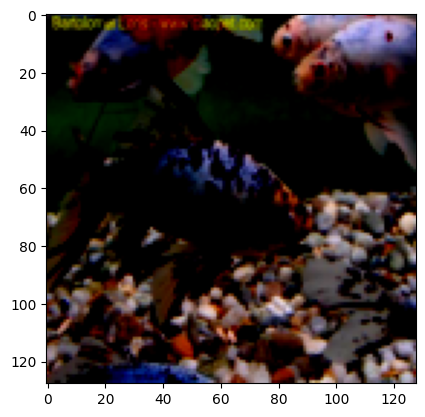

In [7]:
# print a sample image
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [8]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self,num_classes=50):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1,padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling to 1x1
        self.fc1 = nn.Linear(256 * 1 * 1, 128)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(128, num_classes)
        # self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 256 * 1 * 1)  # Reshape to fit fully connected layer
        # x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

# create a complete CNN
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)


In [9]:
# once print the device
print(device)
# specify loss function
criterion = nn.CrossEntropyLoss()

# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 15


# above using tqdm
model.train()
for epoch in range(n_epochs):
    train_loss=0.0
    correct=0
    total=0
    for data, target in tqdm.tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss = train_loss/len(train_loader.dataset)
    acc = 100 * correct / total
    print('Epoch: {} \tTraining Loss: {:.6f} \tAccuracy: {:.2f}'.format(epoch+1, train_loss, acc))

cuda


100%|██████████| 1016/1016 [16:37<00:00,  1.02it/s]


Epoch: 1 	Training Loss: 3.539888 	Accuracy: 9.10


100%|██████████| 1016/1016 [09:56<00:00,  1.70it/s]


Epoch: 2 	Training Loss: 3.117679 	Accuracy: 18.15


100%|██████████| 1016/1016 [09:45<00:00,  1.73it/s]


Epoch: 3 	Training Loss: 2.835031 	Accuracy: 24.32


100%|██████████| 1016/1016 [09:45<00:00,  1.74it/s]


Epoch: 4 	Training Loss: 2.638927 	Accuracy: 28.96


100%|██████████| 1016/1016 [09:48<00:00,  1.73it/s]


Epoch: 5 	Training Loss: 2.484214 	Accuracy: 32.66


100%|██████████| 1016/1016 [09:48<00:00,  1.73it/s]


Epoch: 6 	Training Loss: 2.365758 	Accuracy: 35.38


100%|██████████| 1016/1016 [10:11<00:00,  1.66it/s]


Epoch: 7 	Training Loss: 2.277388 	Accuracy: 37.45


100%|██████████| 1016/1016 [09:53<00:00,  1.71it/s]


Epoch: 8 	Training Loss: 2.193192 	Accuracy: 39.33


100%|██████████| 1016/1016 [09:50<00:00,  1.72it/s]


Epoch: 9 	Training Loss: 2.126116 	Accuracy: 41.07


100%|██████████| 1016/1016 [09:53<00:00,  1.71it/s]


Epoch: 10 	Training Loss: 2.067695 	Accuracy: 42.53


100%|██████████| 1016/1016 [09:46<00:00,  1.73it/s]


Epoch: 11 	Training Loss: 2.013212 	Accuracy: 43.74


100%|██████████| 1016/1016 [09:47<00:00,  1.73it/s]


Epoch: 12 	Training Loss: 1.959807 	Accuracy: 45.20


100%|██████████| 1016/1016 [09:47<00:00,  1.73it/s]


Epoch: 13 	Training Loss: 1.914650 	Accuracy: 46.45


100%|██████████| 1016/1016 [09:46<00:00,  1.73it/s]


Epoch: 14 	Training Loss: 1.879559 	Accuracy: 47.10


100%|██████████| 1016/1016 [09:45<00:00,  1.74it/s]

Epoch: 15 	Training Loss: 1.839906 	Accuracy: 48.30


In [10]:
# predict a sample image
model.eval()
data, target = train_data[0]
data = data.unsqueeze(0).to(device)
output = model(data)
_, pred = torch.max(output, 1)
print("Predicted label: ", train_data.classes[pred.item()])
print("True label: ", train_data.classes[target])

Predicted label:  n01784675
True label:  n01443537


In [11]:
# accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


In [12]:
test_dir="/kaggle/input/iith-dl-contest-2024/test"
test_data = datasets.ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

model.eval()
preds = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        preds += pred.cpu().numpy().tolist()
        
        
print(preds)

[30, 24, 26, 16, 26, 25, 25, 9, 25, 25, 25, 25, 26, 25, 1, 44, 25, 26, 25, 25, 25, 13, 26, 25, 24, 25, 9, 26, 26, 25, 25, 25, 13, 25, 26, 49, 25, 44, 25, 30, 9, 25, 25, 25, 11, 26, 25, 26, 9, 25, 25, 25, 26, 25, 25, 25, 25, 25, 11, 44, 49, 24, 25, 25, 20, 25, 25, 20, 25, 25, 8, 25, 25, 25, 26, 25, 26, 0, 25, 25, 25, 21, 25, 17, 13, 25, 25, 26, 25, 25, 25, 25, 46, 25, 25, 25, 25, 25, 25, 25, 24, 26, 25, 11, 25, 26, 25, 20, 9, 25, 24, 17, 25, 25, 25, 9, 26, 1, 25, 12, 25, 25, 25, 25, 3, 25, 44, 26, 25, 25, 26, 26, 25, 24, 26, 25, 25, 5, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 37, 25, 24, 25, 25, 25, 25, 26, 25, 25, 26, 9, 25, 17, 26, 25, 49, 25, 25, 25, 25, 26, 28, 24, 12, 25, 25, 26, 11, 25, 25, 25, 25, 22, 26, 40, 25, 25, 26, 25, 25, 25, 8, 26, 11, 9, 25, 8, 25, 25, 25, 26, 26, 25, 25, 20, 12, 25, 25, 25, 11, 26, 4, 25, 25, 12, 48, 25, 25, 25, 26, 25, 25, 10, 25, 25, 9, 4, 9, 25, 25, 25, 25, 25, 25, 25, 3, 25, 25, 47, 26, 25, 25, 25, 25, 25, 26, 25, 25, 9, 10, 26, 25, 25, 25, 25, 25, 2

In [13]:
# get class names
class_names = train_data.classes

# generate file names are 1.JPEG, 2.JPEG, etc using for loop
file_names = [str(i)+".JPEG" for i in range(len(preds))]

# sort the file names
file_names.sort()
print(file_names)


['0.JPEG', '1.JPEG', '10.JPEG', '100.JPEG', '1000.JPEG', '10000.JPEG', '10001.JPEG', '10002.JPEG', '10003.JPEG', '10004.JPEG', '10005.JPEG', '10006.JPEG', '10007.JPEG', '10008.JPEG', '10009.JPEG', '1001.JPEG', '10010.JPEG', '10011.JPEG', '10012.JPEG', '10013.JPEG', '10014.JPEG', '10015.JPEG', '10016.JPEG', '10017.JPEG', '10018.JPEG', '10019.JPEG', '1002.JPEG', '10020.JPEG', '10021.JPEG', '10022.JPEG', '10023.JPEG', '10024.JPEG', '10025.JPEG', '10026.JPEG', '10027.JPEG', '10028.JPEG', '10029.JPEG', '1003.JPEG', '10030.JPEG', '10031.JPEG', '10032.JPEG', '10033.JPEG', '10034.JPEG', '10035.JPEG', '10036.JPEG', '10037.JPEG', '10038.JPEG', '10039.JPEG', '1004.JPEG', '10040.JPEG', '10041.JPEG', '10042.JPEG', '10043.JPEG', '10044.JPEG', '10045.JPEG', '10046.JPEG', '10047.JPEG', '10048.JPEG', '10049.JPEG', '1005.JPEG', '10050.JPEG', '10051.JPEG', '10052.JPEG', '10053.JPEG', '10054.JPEG', '10055.JPEG', '10056.JPEG', '10057.JPEG', '10058.JPEG', '10059.JPEG', '1006.JPEG', '10060.JPEG', '10061.JPEG

In [15]:
# print into submission file
with open("/kaggle/working/submission.csv", "w") as f:
    f.write("ID,Category\n")
    for i in range(len(preds)):
        f.write(file_names[i]+","+class_names[preds[i]]+"\n")

In [16]:
torch.save(model.state_dict(),"/kaggle/working/17thapr_sort.pth")
